# MAE 598 Project 1

Trying out multiple intitial states

### Code

In [1]:
# overhead

# import math
import random
import numpy as np
import time
import matplotlib.pyplot as plt

import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import logging

logger = logging.getLogger(__name__)

In [2]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 9.81e-3  # gravity constant (km / s^2)
BOOST_ACCEL = 0.05  # thrust constant (5 gs)

# # # the following parameters are not being used in the sample code
# # PLATFORM_WIDTH = 0.25  # landing platform width
# # PLATFORM_HEIGHT = 0.06  # landing platform height
# # ROTATION_ACCEL = 20  # rotation constant

### Mulitple starts

In [3]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        Units: km, kg, sec, rad
        
        state:
        state[0] = x
        state[1] = y
        state[2] = vx
        state[3] = vy
        state[4] = theta
        
        action:
        action[0]: thrust
        action[1]: step angle
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 


        for i in range(state.shape[0]):
            gravity_influence = t.tensor([[0., -(GRAVITY_ACCEL * (FRAME_TIME ** 2)), 0., -(GRAVITY_ACCEL * FRAME_TIME), 0.]])

            # Thrust and angular control
            action_mat = t.tensor([[(t.sin(state[i, 4]) * (FRAME_TIME ** 2) * BOOST_ACCEL), (t.cos(state[i, 4]) * (FRAME_TIME ** 2) * BOOST_ACCEL), (t.sin(state[i, 4]) * FRAME_TIME * BOOST_ACCEL), (t.cos(state[i, 4]) * FRAME_TIME * BOOST_ACCEL), 0.],
                                   [0., 0., 0., 0., 1.]])
            
            action_influence = t.matmul(action[i], action_mat)
            
            delta = action_influence + gravity_influence
            
            if i == 0:
                delta_batched = delta
                # print(delta_batched, i)
                
            else:
                delta_batched = t.cat((delta_batched, delta), dim=0)
                # print(delta_batched, i)
  
        # print(delta_batched)
        
        state = state + delta_batched
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0.],
                             [FRAME_TIME, 0., 1., 0., 0.],
                             [0., FRAME_TIME, 0., 1., 0.],
                             [0., 0., 0., 0., 1.],])
        prev_state_influence = t.matmul(state, step_mat)
        # print(state.shape)
        # state = prev_state_influence + action_influence + gravity_influence
        state = prev_state_influence

        return state
    
t.autograd.set_detect_anomaly(True)

In [4]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            # nn.Linear(dim_hidden, 2 * dim_hidden),
            # nn.Tanh(),
            # nn.Linear( 2 * dim_hidden, dim_hidden),
            # nn.Tanh(), 
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Tanh()
            # nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        # print("Action: ", action)
        # print("Action dim: ", action.shape)
        return action

In [5]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        batch_sz = 5
        bounds = np.array([[-1, 1], 
                           [10, 15], 
                           [0, 0], 
                           [0, 0], 
                           [0, 1.57]]) # angle in rads
       
        state = t.tensor(np.random.uniform(bounds[:,0], bounds[:, 1], (batch_sz, bounds.shape[0])), requires_grad=False).float()
        print('Dim. state: ', state.shape)
        print('Initial state: ', state)
        return state
    
    
    def error(self, state):
        error = (1 * state[:, 0]**2 + 1 * state[:, 1]**2 + 1 * state[:, 2]**2 + 1 * state[:, 3]**2 + 1 * state[:, 4]**2).mean()
        # error = t.nn.functional.normalize(state, dim=0).mean().sum()
        return error

In [6]:
# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        # self.optimizer = optim.LBFGS(self.parameters, lr=0.1)
        # self.optimizer = optim.Adam(self.parameters, lr=0.01)
        self.optimizer = optim.SGD(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.6f' % (epoch + 1, loss))

            if epoch % 5 == 4:
                self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        
        print(data.shape)
        fig = plt.figure(figsize=(20, 5))       
        ax1 = fig.add_subplot(141)
        ax2 = fig.add_subplot(142)
        ax3 = fig.add_subplot(143)
        ax4 = fig.add_subplot(144)
        for i in range(data.shape[1]):
            x = data[:, i, 0]
            y = data[:, i, 1]

            vx = data[:, i, 2]
            vy = data[:, i, 3]
            
            theta = data[:, i, 4]
            
            ax1.plot(x, y)
            # ax1.set_xlim(-0.5, 0.5)
            # ax1.set_ylim(0, 10)
            
            ax2.plot(vx)
            # ax2.set_xlim(0, data.shape[0])
            # ax2.set_ylim(0, 100)
            
            ax3.plot(vy)
            # ax3.set_xlim(0, data.shape[0])
            # ax3.set_ylim(0, 100)
            
            ax4.plot(theta)
            # ax4.set_xlim(0, data.shape[0])
            # ax4.set_ylim(0, 100)
        plt.show()

Dim. state:  torch.Size([5, 5])
Initial state:  tensor([[ 0.1554, 12.5266,  0.0000,  0.0000,  1.2657],
        [ 0.7411, 14.0951,  0.0000,  0.0000,  1.2489],
        [-0.3714, 13.9735,  0.0000,  0.0000,  1.5495],
        [-0.6628, 14.2846,  0.0000,  0.0000,  0.9242],
        [-0.8116, 13.8779,  0.0000,  0.0000,  1.3204]])
[1] loss: 574.372375
[2] loss: 412.889557
[3] loss: 77.848869
[4] loss: 90.227081
[5] loss: 22.131973
(200, 5, 5)


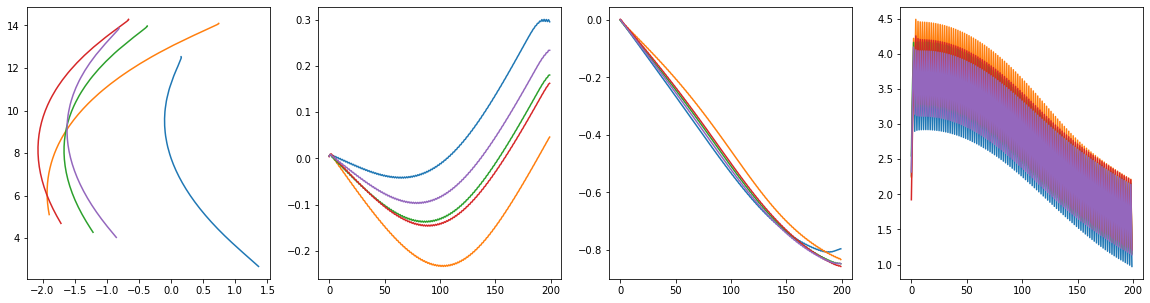

[6] loss: 50.117035
[7] loss: 323.518311
[8] loss: 257.838928
[9] loss: 404.651184
[10] loss: 32.144192
(200, 5, 5)


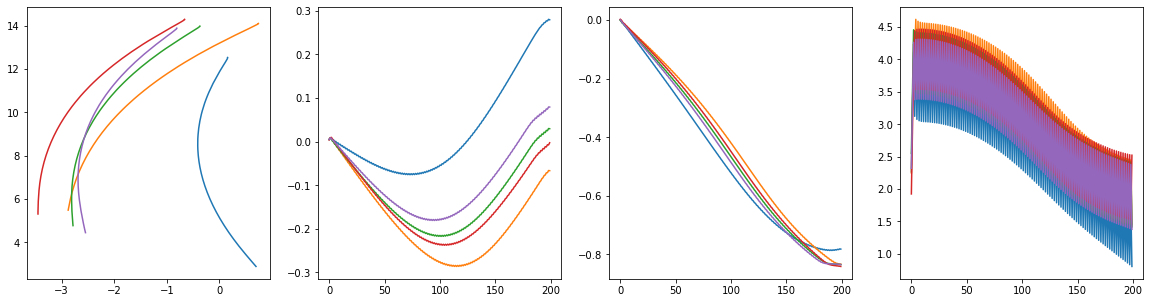

In [7]:
# Now it's time to run the code!

T = 200  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(10)  # solve the optimization problem
